In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import col, month, year, hour, to_timestamp, window, avg, count
from pyspark.sql.functions import to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
            .appName("PA Accident Analysis Continuous (2018-2021)") \
            .config('spark.executor.memory', '2g') \
            .config('spark.driver.memory', '8g') \
            .getOrCreate()

# Load the dataset
df_raw = spark.read.format("csv") \
    .option("header", "true") \
    .load("data/RMSTRAFFIC_(Traffic_Volumes).csv")

df_pa = df_raw

# Define the date format
date_format = "yyyyMMdd"

# Convert string to date and then to timestamp
df_pa = df_pa.withColumn("RECORD_UPDATE", to_timestamp(to_date(col("RECORD_UPDATE"), date_format)))



In [14]:
df_pa.show(vertical=True)


-RECORD 0----------------------------------
 OBJECTID           | 1                    
 RMSTRAFFIC_LRS_KEY | 62402100100000004... 
 ST_RT_NO           | 4021                 
 CTY_CODE           | 62                   
 DISTRICT_NO        | 12                   
 JURIS              | 1                    
 SEG_BGN            | 0010                 
 OFFSET_BGN         | 0                    
 SEG_END            | 0040                 
 OFFSET_END         | 2227                 
 SEG_PT_BGN         | 00100000             
 SEG_PT_END         | 00402227             
 SEG_LNGTH_FEET     | 9714                 
 SEQ_NO             | 1                    
 CUR_AADT           | 599                  
 ADTT_CUR           | 46                   
 TRK_PCT            | 8                    
 WKDY_TRK_CUR       | 59                   
 ADLR_TRK_CUR       | 13                   
 ADLF_TRK_CUR       | 12                   
 BASE_YR_CLS_CNT    | 2020                 
 BASE_ADT           | 527       

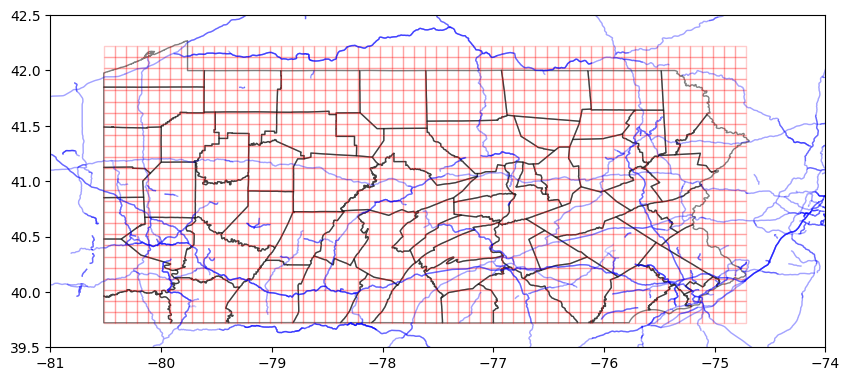

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Load the Pennsylvania counties map from the GeoJSON file
pa_gdf = gpd.read_file("PaCounty2023_10.geojson")
pa_gdf = pa_gdf.set_index("COUNTY_NAM")

# Load the US primary roads data
pa_map = gpd.read_file('data/tl_2022_us_primaryroads/tl_2022_us_primaryroads.shx')

# Create the grid
xmin, ymin, xmax, ymax = pa_gdf.total_bounds
width = height = 0.1  # size of the square in degrees, adjust as needed

rows = int((ymax - ymin) / height)
cols = int((xmax - xmin) / width)
squares = []

count = []
k = 0
for i in range(cols):
    for j in range(rows):
        minx = xmin + i * width
        maxx = minx + width
        miny = ymin + j * height
        maxy = miny + height
        
        k = k + 1
        squares.append(box(minx, miny, maxx, maxy))
        count.append(k)

gdf_grid = gpd.GeoDataFrame({'geometry': squares, 'ID':count })

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)  # Plot primary roads in blue
gdf_grid.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.2)  # Overlay the grid

ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
plt.show()


In [2]:
gdf_grid

,geometry,ID
0,"POLYGON ((-80.41939 39.71986, -80.41939 39.819...",1
1,"POLYGON ((-80.41939 39.81986, -80.41939 39.919...",2
2,"POLYGON ((-80.41939 39.91986, -80.41939 40.019...",3
3,"POLYGON ((-80.41939 40.01986, -80.41939 40.119...",4
4,"POLYGON ((-80.41939 40.11986, -80.41939 40.219...",5
...,...,...
1445,"POLYGON ((-74.71939 41.71986, -74.71939 41.819...",1446
1446,"POLYGON ((-74.71939 41.81986, -74.71939 41.919...",1447
1447,"POLYGON ((-74.71939 41.91986, -74.71939 42.019...",1448
1448,"POLYGON ((-74.71939 42.01986, -74.71939 42.119...",1449


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import col, month, year, hour, to_timestamp, window, avg, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
            .appName("PA Accident Analysis Continuous (2018-2021)") \
            .config('spark.executor.memory', '2g') \
            .config('spark.driver.memory', '8g') \
            .getOrCreate()

# Load the dataset
df_raw = spark.read.format("csv") \
    .option("header", "true") \
    .load("data/US_Accidents_March23.csv")

# Filter for Pennsylvania
df_pa = df_raw.filter(df_raw["State"] == "PA")#.sample(fraction=0.001)

# Convert columns to appropriate types
df_pa = df_pa.withColumn("Start_Lat", col("Start_Lat").cast(DoubleType()))
df_pa = df_pa.withColumn("Start_Lng", col("Start_Lng").cast(DoubleType()))

df_pa = df_pa.withColumn('Start_Time', to_timestamp(col('Start_Time')))

23/12/19 03:44:45 WARN Utils: Your hostname, diego-swamslab resolves to a loopback address: 127.0.1.1; using 128.180.200.192 instead (on interface wlp0s20f3)
23/12/19 03:44:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 03:44:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType
import geopandas as gpd
import shapely
import pandas as pd

# Convert gdf to a GeoPandas DataFrame
# gdf = gpd.read_file('your_file.geojson')

@pandas_udf(DoubleType())
def find_grid_udf(latitudes, longitudes):
    points = gpd.GeoSeries(gpd.points_from_xy(longitudes, latitudes))
    grids = []  # Initialize the list outside the loop

    for point in points:
        grid = None  # Initialize grid as None for each point
        for idx, row in gdf_grid.iterrows():
            if row['geometry'].intersects(point):
                grid = row['ID']
                break
        grids.append(grid)  # Append the found grid (or None) to the grids list

    return pd.Series(grids)

df_pa_with_grid = df_pa.withColumn("grid", find_grid_udf("Start_Lat", "Start_Lng"))


In [5]:
df_pa_with_grid.show(vertical=True)

23/12/19 03:44:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------------
 ID                    | A-197867             
 Source                | Source2              
 Severity              | 3                    
 Start_Time            | 2016-12-26 14:00:12  
 End_Time              | 2016-12-26 14:45:00  
 Start_Lat             | 41.338398            
 Start_Lng             | -74.83712            
 End_Lat               | NULL                 
 End_Lng               | NULL                 
 Distance(mi)          | 0.01                 
 Description           | Accident on I-84 ... 
 Street                | I-84 E               
 City                  | Milford              
 County                | Pike                 
 State                 | PA                   
 Zipcode               | 18337                
 Country               | US                   
 Timezone              | US/Eastern           
 Airport_Code          | KFWN                 
 Weather_Timestamp     | 2016-12-26 13:53:00  
 Temperature(

/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


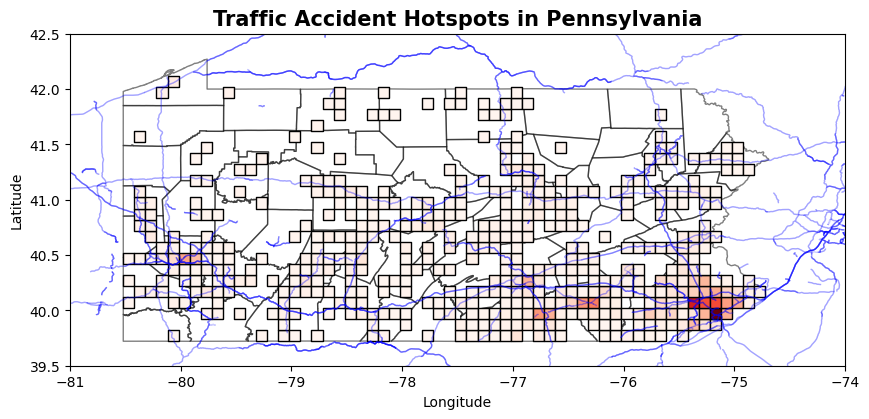

In [11]:
from pyspark.sql.functions import year, month

# Assuming df_pa has a 'Start_Time' column in timestamp format


# Filter for a specific year and month (e.g., May 2023)
target_year = 2020
target_month = 10

df_pa_filtered = df_pa_with_grid.filter((year(df_pa_with_grid.Start_Time) == target_year) & (month(df_pa_with_grid.Start_Time) == target_month))

grid_counts_filtered = df_pa_filtered.groupBy("grid").count()

# Convert to Pandas DataFrame for merging
pd_grid_counts_filtered = grid_counts_filtered.toPandas()


# Merge with grid GeoDataFrame
merged_gdf_filtered = gdf_grid.merge(pd_grid_counts_filtered, left_on='ID', right_on='grid', how='left')

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap for the specific year and month
merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, alpha=1, edgecolor='k')

# Enhancements
ax.set_title("Traffic Accident Hotspots in Pennsylvania", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal')

ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])

# Save and show the plot
plt.savefig('pa_traffic_accidents_map_2020_10.png')

plt.show()


In [39]:
from pyspark.sql.functions import year, month
import matplotlib.colors as colors

# Assuming df_pa has a 'Start_Time' column in timestamp format


# Filter for a specific year and month (e.g., May 2023)
target_year = 2019
target_month = 10

df_pa_filtered = df_pa_with_grid.filter((year(df_pa_with_grid.Start_Time) == target_year) & (month(df_pa_with_grid.Start_Time) == target_month))

grid_counts_filtered = df_pa_filtered.groupBy("grid").count()

# Convert to Pandas DataFrame for merging
pd_grid_counts_filtered = grid_counts_filtered.toPandas()


# Merge with grid GeoDataFrame
merged_gdf_filtered = gdf_grid.merge(pd_grid_counts_filtered, left_on='ID', right_on='grid', how='left')

vmin, vmax = pd_grid_counts_filtered['count'].quantile([0.1, 0.9])


/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

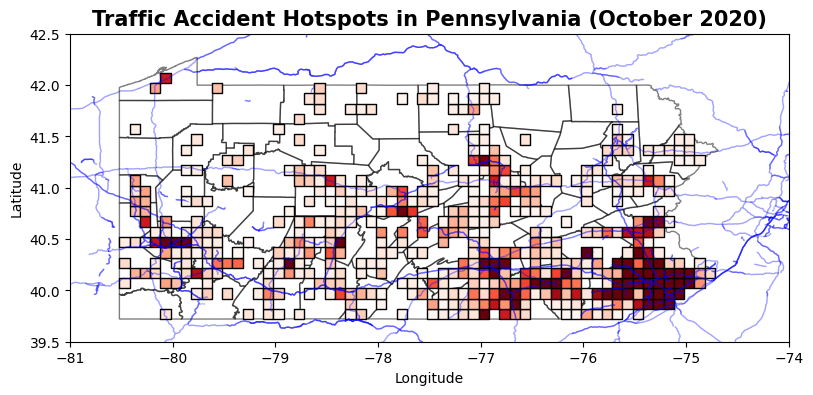

In [38]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap with normalized color intensity
merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, 
                                   norm=colors.Normalize(vmin=vmin, vmax=vmax), 
                                   edgecolor='k')

# Enhancements for readability
ax.set_title("Traffic Accident Hotspots in Pennsylvania (October 2020)", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
ax.set_aspect('equal')

plt.savefig('pa_traffic_accidents_map_2020_10.png')

plt.show()

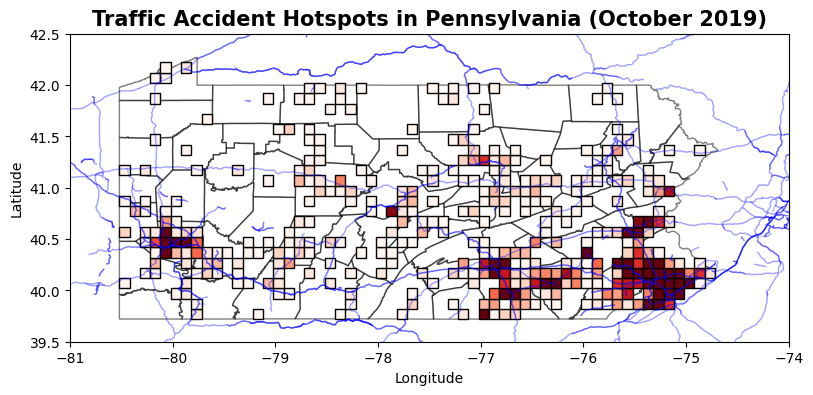

In [40]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap with normalized color intensity
merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, 
                                   norm=colors.Normalize(vmin=vmin, vmax=vmax), 
                                   edgecolor='k')

# Enhancements for readability
ax.set_title("Traffic Accident Hotspots in Pennsylvania (October 2019)", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
ax.set_aspect('equal')

plt.savefig('pa_traffic_accidents_map_2019_10.png')

plt.show()

/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

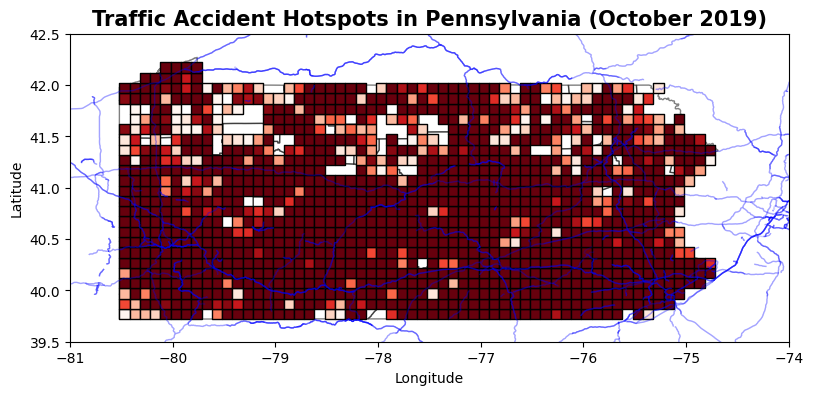

In [43]:
from pyspark.sql.functions import year, month

# Assuming df_pa has a 'Start_Time' column in timestamp format


# Filter for a specific year and month (e.g., May 2023)
target_year = 2020
target_month = 10

df_pa_filtered = df_pa_with_grid.sample(fraction=0.001)

grid_counts_filtered = df_pa_with_grid.groupBy("grid").count()

# Convert to Pandas DataFrame for merging
pd_grid_counts_filtered = grid_counts_filtered.toPandas()


# Merge with grid GeoDataFrame
merged_gdf_filtered = gdf_grid.merge(pd_grid_counts_filtered, left_on='ID', right_on='grid', how='left')

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap with normalized color intensity
merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, 
                                   norm=colors.Normalize(vmin=vmin, vmax=vmax), 
                                   edgecolor='k')

# Enhancements for readability
ax.set_title("Traffic Accident Hotspots in Pennsylvania (October 2019)", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
ax.set_aspect('equal')

plt.savefig('pa_traffic_accidents_map_all.png')

plt.show()

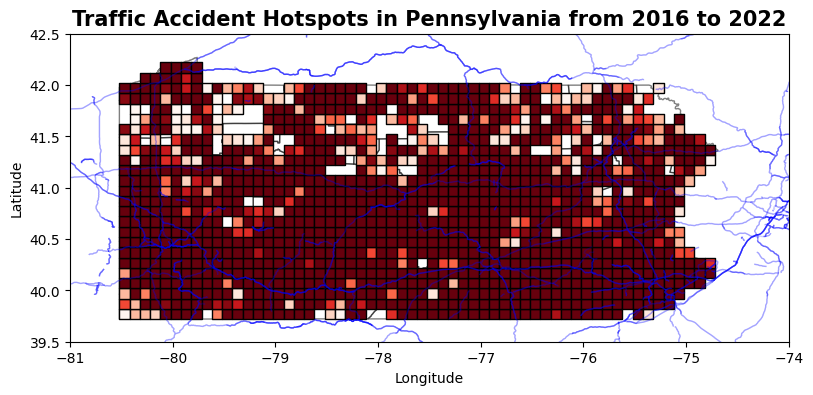

In [47]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap with normalized color intensity
merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, 
                                   norm=colors.Normalize(vmin=vmin, vmax=vmax), 
                                   edgecolor='k')

# Enhancements for readability
ax.set_title("Traffic Accident Hotspots in Pennsylvania from 2016 to 2022", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
ax.set_aspect('equal')

plt.savefig('pa_traffic_accidents_map_all.png')

plt.show()

In [52]:
from pyspark.sql.functions import year, month

# Assuming df_pa has a 'Start_Time' column in timestamp format


# Filter for a specific year and month (e.g., May 2023)
target_year = 2020
target_month = 10

df_pa_filter = df_pa.select("Start_Lng", "Start_Lat")
df_pa_filtered = df_pa_filter.sample(fraction=0.0001)

# Then proceed with converting to Pandas DataFrame and to GeoDataFrame
df_pd = df_pa_filtered.toPandas()
gdf_df = gpd.GeoDataFrame(df_pd, geometry=gpd.points_from_xy(df_pd.Start_Lng, df_pd.Start_Lat))




/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/diego/.local/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

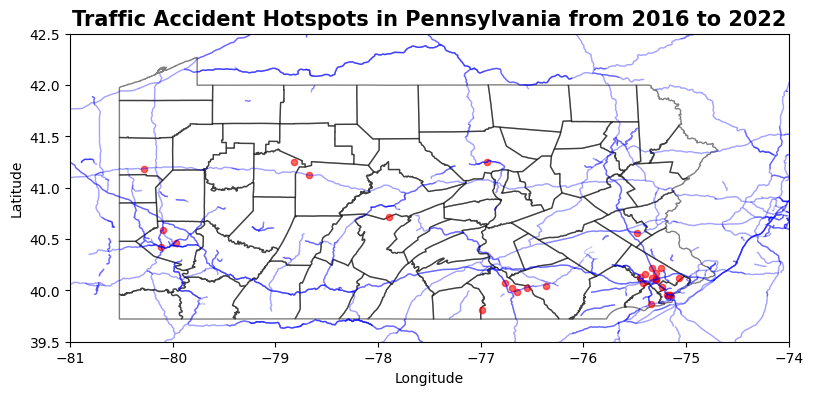

In [53]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 4))
pa_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.5)
pa_map.plot(ax=ax, color='blue', linewidth=1, alpha=0.2)

# Create the heatmap with normalized color intensity
# merged_gdf_filtered.plot(ax=ax, column='count', cmap='Reds', legend=False, 
                                   # norm=colors.Normalize(vmin=vmin, vmax=vmax), 
                                   # edgecolor='k')

gdf_df.plot(ax=ax, marker='o', color='red', markersize=20, alpha=0.6)  # Adjust alpha for transparency

# Enhancements for readability
ax.set_title("Traffic Accident Hotspots in Pennsylvania from 2016 to 2022", fontsize=15, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-81, -74])
ax.set_ylim([39.5, 42.5])
ax.set_aspect('equal')

plt.savefig('pa_traffic_accidents_map_all_points.png')

plt.show()